In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 12 18:29:09 2022
Gravity inversion in wavenumber domain
@author: chens
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pathlib
# local imports
import freqinv.su as su

2000.0
512
(64, 16) (64, 16)
inversion use time:  0:00:03.719044
field recover misfit:  0.13000560411494178
freq recover misfit:  1.42436407945432
freq(abs) recover misfit:  1.3510147076543844
freq(angle) recover misfit:  2.0093468929732587
rhs recover misfit:  0.03339383494515416
(64, 64)
(64, 64)


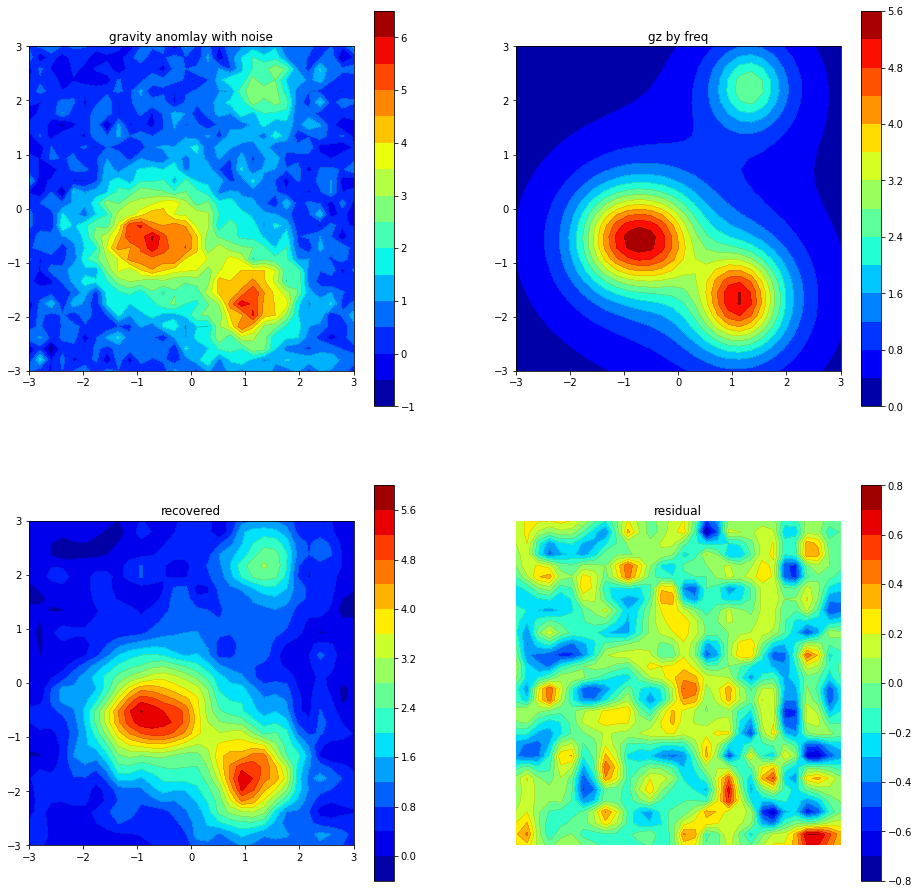

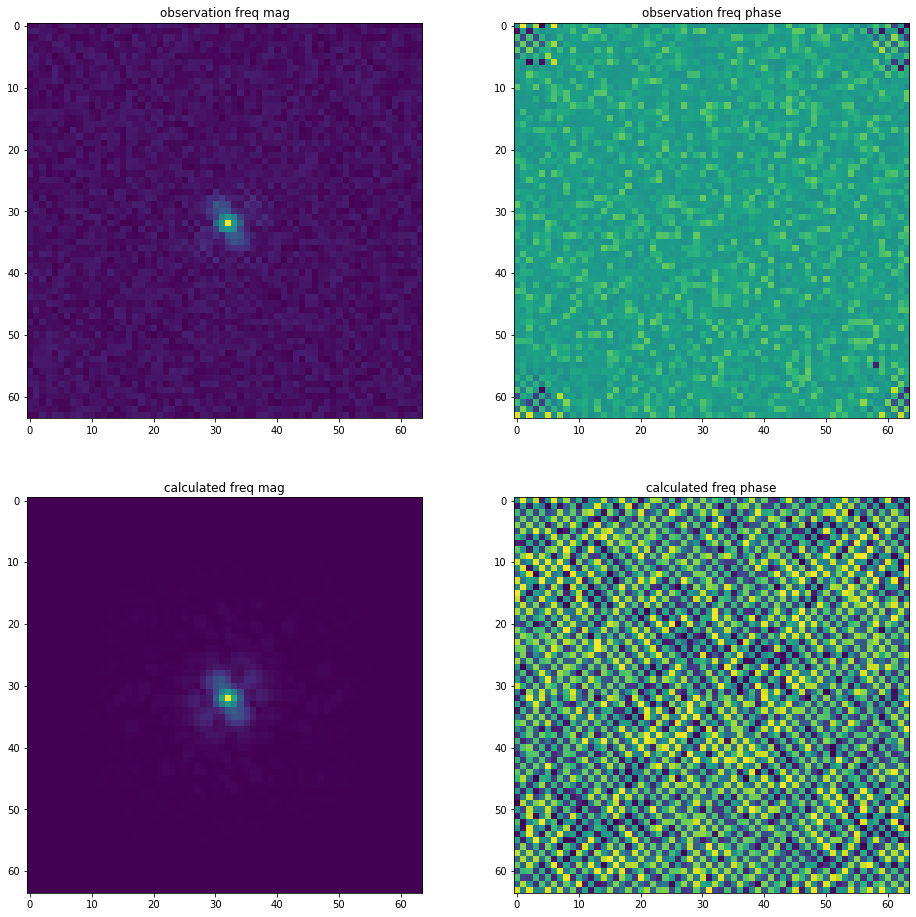

In [2]:
if __name__ == '__main__':
    # define model volume and grid shape

    work_dir = '.'
        #geoist.TEMP_PATH #pathlib.Path('/home/zhangb/work/people/zhangbei/freq')
    nzyx = [2,16,16]  # The grid setting of field source, [z,y,x] are the number of meshes in the three directions, respectively
    source_volume = [-3000, 3000, -3000, 3000, 100, 1000] # Field source distribution range, [xmin,xmax,ymin,ymax,zmin,zmax]
    obs_area = [-3000,3000,-3000,3000] # Observation area,[xmin,xmax,ymin,ymax]
    nobsyx = [30,30] # The number of lattice points of the observation field, which are the number of lattice points in the y and x directions, respectively

    model_density = np.zeros(tuple(nzyx)) # Density model used for forward
    model_density[1:2,4:8,5:8] = 1000
    model_density[1:2,10:12,2:5] = 1500
    model_density[1:2,11:12,13:15] = 2000

    refer_densities = [] # A list of inverted reference models, each member of which is a reference density model.
    weights = {'refers':[0.001]} # trade-off for reference model.
    refer_density = np.zeros(tuple(nzyx)) # Set a reference model with density equals zero, which is equivalent to the minimum model constraint
    refer_density = refer_density.ravel()
    refer_densities.append(refer_density) # Add the reference model to reference list

    small_model = su.FreqInvModel(nzyx=nzyx,
                                       source_volume=source_volume,
                                       nobsyx=nobsyx,
                                       obs_area=obs_area,
                                       model_density=model_density,
                                       weights=weights,
                                       refer_densities=refer_densities)
    small_model.gen_mesh(height=1.)  # Grid generation
    small_model.gen_kernel() # kernel function generation
    small_model.forward(update=True) # Forward
                                     # If the density source is not given, use small_model.model_density as the density source.
                                     # If update=True,update small_model.freq and small_model.obs_field as forward result.
                                     # If update=False,return the result of the calculation，small_model.freq and small_model.obs_field will not change.
    true_freq = small_model.freq     # Back up true frequency domain gravity
    small_model.obs_freq = small_model.freq # small_model.obs_freq,The observed gravity in frequency domain.
    # add noise
    #real_noise = 0.1*np.max(np.abs(small_model.obs_freq.real))
    #imag_noise = 0.1*np.max(np.abs(small_model.obs_freq.imag))
    real_noise = 0.05*(np.max(small_model.obs_freq.real)-np.min(small_model.obs_freq.real))
    imag_noise = 0.05*(np.max(small_model.obs_freq.imag)-np.min(small_model.obs_freq.imag)) 
    mshapex, mshapey = small_model.obs_freq.shape    
    small_model.obs_freq += real_noise*np.random.rand(mshapex, mshapey) + imag_noise*np.random.rand(mshapex, mshapey)*1j
    
    fieldt= np.real(np.fft.ifft2(small_model.obs_freq))
    fieldn = fieldt[small_model.padx: small_model.padx + nobsyx[1], small_model.pady: small_model.pady + nobsyx[0]].ravel()
    print(np.max(small_model._model_density))
    print(len(small_model._model_density))
    print(np.conj(small_model.FX).shape,small_model.FY.shape)
    st = datetime.datetime.now()
    small_model.do_linear_solve_quiet() # Inversion, The results save to small_model.solution.
    ed = datetime.datetime.now()
    print("inversion use time: ",ed-st)

# check solution
    freq,recover = small_model.forward(small_model.solution.real) # Predict gravity using the inversion result.
    print('field recover misfit: ',np.linalg.norm(recover - small_model.obs_field)/np.linalg.norm(small_model.obs_field)) # Gravity misfit between predicted gravity and true gravity.
    print('freq recover misfit: ',np.linalg.norm(freq - true_freq)/np.linalg.norm(freq)) # Relative error of predicted field and true field in frequency domain. 
    print('freq(abs) recover misfit: ',np.linalg.norm(np.abs(freq)
                                                      - np.abs(true_freq))/np.linalg.norm(np.abs(freq))) # Relative error of norm for predicted field and true field in frequency domain.
    angle_diff = (np.angle(freq) - np.angle(true_freq)) % (np.pi*2)
    print('freq(angle) recover misfit: ',np.linalg.norm(angle_diff)/np.linalg.norm(np.angle(freq))) # Relative error of argument for predicted field and true field in frequency domain.
    rhs = small_model.C*small_model.W*freq.T.ravel()
    rhs = small_model.dW.T*rhs
    rhs = su.kron_matvec([np.conj(small_model.FY.T),
                               np.conj(small_model.FX.T)],
                              rhs.reshape(small_model.nz,-1)).ravel()
    print('rhs recover misfit: ',np.linalg.norm(rhs - small_model.rhs)/np.linalg.norm(small_model.rhs)) # Check for the right-end term of the equation.
# save density model to vtk, comment out this section if gridToVTK not installed.
    nz,ny,nx = nzyx
    arr = small_model.solution.real.copy()
    xs = np.zeros((nz+1,ny+1,nx+1)) + np.array(small_model.mesh.get_xs()).reshape(1,1,-1)
    ys = np.zeros((nz+1,ny+1,nx+1)) + np.array(small_model.mesh.get_ys()).reshape(1,-1,1)
    zs = np.zeros((nz+1,ny+1,nx+1)) + np.array(small_model.mesh.get_zs()).reshape(-1,1,1)
#    gridToVTK(str(work_dir/"results"),xs,ys,zs,cellData={"recover":arr.reshape(nz,ny,nx),
#                                             "orig":model_density})
#
    field0 = su.gz(small_model.xp, small_model.yp, small_model.zp, small_model.mesh)
    shape = (nobsyx[0],nobsyx[1])

# plot field
    fig = plt.figure(figsize=(16, 16))
    
    # original field
    axes = fig.subplots(2,2)
#    plt.axis('scaled')
    ca = axes[0][0]
    plt.sca(ca)
    plt.axis('scaled')
    levels = su.contourf(small_model.yp * 0.001, small_model.xp * 0.001, fieldn, shape, 15)
    cb = plt.colorbar()
    su.contour(small_model.yp * 0.001, small_model.xp * 0.001, fieldn, shape,
                levels, clabel=False, linewidth=0.1)
    ca.set_title('gravity anomlay with noise')

    # field from frequency
    ca = axes[0][1]
    plt.sca(ca)
    plt.axis('scaled')
#    levels = su.contourf(small_model.yp * 0.001, small_model.xp * 0.001,
#    small_model.obs_field, shape, 15)
    levels = su.contourf(small_model.yp * 0.001, small_model.xp * 0.001, small_model.obs_field, shape, 15)
    cb = plt.colorbar()
    su.contour(small_model.yp * 0.001, small_model.xp * 0.001, small_model.obs_field, shape,
                levels, clabel=False, linewidth=0.1)
    ca.set_title('gz by freq')

    # field recovered from solution
    ca = axes[1][0]
    plt.sca(ca)
    plt.axis('scaled')
#    levels = su.contourf(small_model.yp * 0.001, small_model.xp * 0.001, recover, shape, 15)
    levels = su.contourf(small_model.yp * 0.001, small_model.xp * 0.001, recover, shape, 15)
    cb = plt.colorbar()
    su.contour(small_model.yp * 0.001, small_model.xp * 0.001, recover, shape,
                levels, clabel=False, linewidth=0.1)
    ca.set_title('recovered')
    
    # field residual 
    ca = axes[1][1]
    plt.sca(ca)
    plt.axis('scaled')
    residual = recover-small_model.obs_field
    levels = su.contourf(small_model.yp * 0.001, small_model.xp * 0.001, residual, shape, 15)
    cb = plt.colorbar()
    su.contour(small_model.yp * 0.001, small_model.xp * 0.001, residual, shape,
                levels, clabel=False, linewidth=0.1)
    ca.set_title('residual')
    #ca = axes[1][1]
    ca.axis('off')
    #plt.savefig(pathlib.Path(work_dir,'field.jpg'))

    # plot frequency
    fig = plt.figure(figsize=(16, 16))
    axes = fig.subplots(2,2)
    
    # spectrum observation
    freq = true_freq
    np.savetxt(pathlib.Path(work_dir,'true_freq.txt'),freq)
    # mag
    ca = axes[0][0]
    ca.imshow(np.abs(np.fft.fftshift(freq)))
    ca.set_title('observation freq mag')
    # phase
    ca = axes[0][1]
    ca.imshow(np.angle(freq))
    ca.set_title('observation freq phase')
    print(freq.shape)
    
    # spectrum calculated
    freq,recover = small_model.forward(small_model.solution.real)
    np.savetxt(pathlib.Path(work_dir,'recover_freq.txt'),freq)
    print(freq.shape)
    
    # mag
    ca = axes[1][0]
    ca.imshow(np.abs(np.fft.fftshift(freq)))
    ca.set_title('calculated freq mag')
    # phase
    ca = axes[1][1]
    ca.imshow(np.angle(freq))
    ca.set_title('calculated freq phase')

    #plt.savefig(pathlib.Path(work_dir,'frequency.jpg'))
    
# save data
    
    origf = np.transpose(fieldn.reshape(nobsyx))
    invf = np.transpose(recover.reshape(nobsyx))
    resf = np.transpose(residual.reshape(nobsyx))
    grd0 = su.grddata()
    grd0.cols, grd0.rows = np.shape(origf)
    grd0.xmin = obs_area[0]
    grd0.xdim = (obs_area[1]- obs_area[0])/(grd0.cols-1)
    grd0.ymin = obs_area[2]
    grd0.ydim = (obs_area[3]- obs_area[2])/(grd0.rows-1)        
    grd0.data =np.ma.masked_equal(origf, grd0.nullvalue)
    #grd0.export_surfer(r'.\\origf_m2.grd', True,'a')
    
    grd1 = su.grddata()
    grd1.cols, grd1.rows = np.shape(invf)
    grd1.xmin = obs_area[0]
    grd1.xdim = (obs_area[1]- obs_area[0])/(grd1.cols-1)
    grd1.ymin = obs_area[2]
    grd1.ydim = (obs_area[3]- obs_area[2])/(grd1.rows-1)        
    grd1.data =np.ma.masked_equal(invf, grd1.nullvalue)
    #grd1.export_surfer(r'.\\invf_m2.grd', True,'a')

    grd2 = su.grddata()
    grd2.cols, grd2.rows = np.shape(resf)
    grd2.xmin = obs_area[0]
    grd2.xdim = (obs_area[1]- obs_area[0])/(grd2.cols-1)
    grd2.ymin = obs_area[2]
    grd2.ydim = (obs_area[3]- obs_area[2])/(grd2.rows-1)        
    grd2.data =np.ma.masked_equal(resf, grd2.nullvalue)
    #grd2.export_surfer(r'.\\resf_m2.grd', True,'a')
    
#    df1 = pd.DataFrame(columns=['x','y','z','g_orig','g_recover'])
#    df1['x'] = small_model.yp
#    df1['y'] = small_model.xp
#    df1['z'] = small_model.zp
#    df1['g_orig'] = field0
#    df1['g_recover'] = small_model.obs_field
#    df1.to_csv('freq.txt')
#
    rimpl = np.log(np.abs(np.fft.fftshift(freq)))
    grd1=su.grddata()
    grd1.cols, grd1.rows = np.shape(rimpl)
    grd1.xmin = -32
    grd1.xdim = 1
    grd1.ymin = -32
    grd1.ydim = 1    
    grd1.data =np.ma.masked_equal(rimpl, grd1.nullvalue)
    #grd1.export_surfer(r'.\\impl_m2_i03.grd', True,'a')
    rangle = np.angle(freq)
    grd2=su.grddata()
    grd2.cols, grd2.rows = np.shape(freq)
    grd2.xmin = -32
    grd2.xdim = 1
    grd2.ymin = -32
    grd2.ydim = 1     
    grd2.data =np.ma.masked_equal(rangle, grd1.nullvalue)
    #grd2.export_surfer(r'.\\angle_m2_i03.grd', True,'a')        
# save model
    modelreal = model_density[1,:,:]
    modelinv = arr.reshape(nz,ny,nx)[1,:,:]

    grd0=su.grddata()
    grd0.cols, grd0.rows = np.shape(modelreal)
    grd0.xmin = source_volume[0]
    grd0.xdim = (source_volume[1]- source_volume[0])/(grd0.cols-1)
    grd0.ymin = source_volume[2]
    grd0.ydim = (source_volume[3]- source_volume[2])/(grd0.rows-1)        
    grd0.data =np.ma.masked_equal(modelreal, grd0.nullvalue)
    #grd0.export_surfer(r'.\\real_m2.grd', True,'a')
    
    grd1=su.grddata()
    grd1.cols, grd1.rows = np.shape(modelinv)
    grd1.xmin = source_volume[0]
    grd1.xdim = (source_volume[1]- source_volume[0])/(grd1.cols-1)
    grd1.ymin = source_volume[2]
    grd1.ydim = (source_volume[3]- source_volume[2])/(grd1.rows-1)        
    grd1.data =np.ma.masked_equal(modelinv, grd1.nullvalue)
    #grd1.export_surfer(r'.\\inv_m2_10.grd', True,'a')